# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import pandas as pd

## <span style="color:blue"> Read & Normalize data </span>

Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 0 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

col_labels = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [3]:
# M_train = data_train
# M_test = data_test 
# moy = np.zeros((8,))
# sigma = np.zeros((8,))

# With a FOR loop :
# for k in range(8): # 8 columns of entries
#     moy[k]=np.mean(data_train[:,k])
#     sigma[k] = np.std(data_train[:,k])
#     M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
#     M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

In [4]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)                     # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST

# expectation and std deviation
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec) for vec in data_train[:,0:8].T ] )

# normalized test set w.r.t to the training set
M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# <span style="color:blue"> Part 1 : simple least square regression </span>

## Preliminary questions

 
1. Compute the autocovariance matrix from the training set.
2. Observe carefully & Comment. What kind of information can you get ? 

#### <span style="color:#c83349"> <ins> Question 1 : Covariance matrix of the training set </ins></span>

The covariance matrix describes how 2 R.V. (Random Variables) change together : 

\begin{equation}
cov(X, Y) = \mathop{\mathbb{E}}[(X - \bar{X})(Y - \bar{Y})] =\langle\,X - \bar{X},Y - \bar{Y}\rangle 
\end{equation}


A ***positive value*** of the covariance means a change in the same direction of the 2 features (if one increases, so does the other). 

On the other hand, a ***negative value*** of the covariance means a change in opposite directions (if one increases, the other decreases, and vice-versa).

<AxesSubplot:>

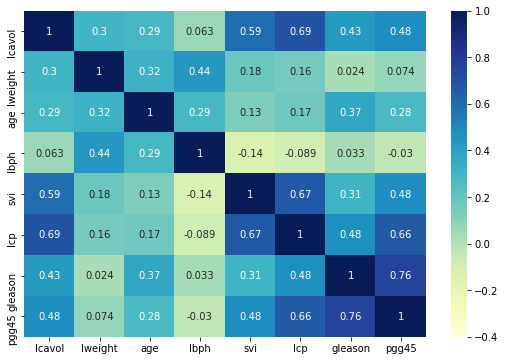

In [5]:
import seaborn as sns

# Autocovariance matrix of the training set 
df_cov = pd.DataFrame(np.cov(M_train.T, bias = True), index= col_labels, columns=col_labels)

# heat map of the correlation coefficients
plt.figure(figsize=(9, 6))
sns.heatmap(df_cov, annot=True, vmin = -0.4, vmax = 1, cmap="YlGnBu")   

***Remark :*** 
Using `bias = True`, helps getting unbiased covariance and variance values (if not used, we get a variance of $1.015 \approx 1/67$, with 67 = the nb of rows in the train set). This is somehow equivalent to using the correlation matrix (`np.corrcoef(M_train.T)`) in place of the covariance matrix.

#### <span style="color:#c83349"> <ins>Question 2 : Comments </ins></span>

* The correlation coefficients score a magnitude in the range $[-1, 1]$, with $\pm 1$ as a sign of higly correlated features, and 0 for independent features. 

* The diagonale of the covariance matrix is composed of the variance values of the features (which is $=1$).


* The following  pairs of features : (lcavol, lcp), (svi, lcp), (pgg45, gleason), (pgg45, lcp) have relatively strong correlation coefficients ( $> 0.66$). This implies that ***the features of the training set are not completely linearly independent***. This might suggest to keep only some of them. 

In fact, ***when the features are correlated***, the projection of the target vector onto the space spanned by the columns (features) of the input matrix is not unique. Therefore, ***solving the regression problem in the sense of the LS would result in poorly determined weights (regression vector) and hence a high variance***. 

For good prediction results, we would better opt for ***reducing the dimensions of the input*** using ***ridge regression*** for instance. 


**Remark** : We can also look into the covariance of the input + the target  

In [6]:
# normalizing the target
normalized_target = normalize(data_train[:, 8])

# concatenation of the input and the target
input_and_target = np.concatenate((M_train, np.array([normalized_target]).T), axis = 1)

<AxesSubplot:>

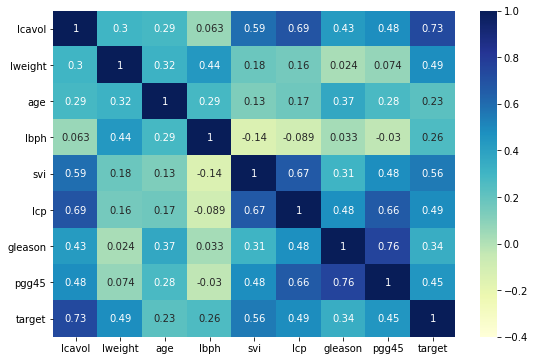

In [7]:
col_labels1 = col_labels + ['target']

# heatmap of the correlation coefficients
plt.figure(figsize=(9, 6))
sns.heatmap(pd.DataFrame(np.cov(input_and_target.T, bias = True), index= col_labels1, columns=col_labels1), annot=True, vmin = -0.4, vmax = 1, cmap="YlGnBu") 

***Comments :*** As the covariance of the features and the target suggests, some features contribute to the value of the target more than others (namely : `lcavol`, `svi`).

## Exercise 1 : least square regression 
1. Build the matrix of features `X_train` for the training set, the first column is made of ones.
2. Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
3. What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
4. Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

#### <span style="color:#c83349"> <ins>Question 1 : Building $X\_train$ matrix </ins></span>

In [8]:
# matrix of the features, with the 1st column made of ones 
t_train = data_train[:, 8]
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1)

#### <span style="color:#c83349"> <ins>Question 2 : Estimation of $\hat \beta$</ins> </span>

In [9]:
dag_X_train = np.dot(la.inv(np.dot(X_train.T, X_train)), X_train.T)
beta_hat = np.dot(dag_X_train, t_train)
print(beta_hat)

[ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]


#### <span style="color:#c83349"> <ins>Question 3 : Value of the intercept (bias)</ins> </span>

The value of the 1st coefficient is $2.45$. It corresponds to the estimated value of the bias $\hat\beta_0$ : 
\begin{equation}
\hat\beta = 
\begin{bmatrix}
\hat\beta_0\\
\hat\beta_1\\
...\\
\hat\beta_{p}
\end{bmatrix}
\end{equation}
where $p$ is the number of features.


#### <span style="color:#c83349"> <ins>Question 4 : Prediction error from the test set </ins></span>

We need to ***normalize the test dataset*** as well, since the model is trained on a normalized training set. However, the test set should be normalized with respect to the training set. 

*One might think of normalizing the dataset before train-test split. But this would raise an **information leakage** issue.*

In [10]:
t_test = data_test[:,8]          # target column
N_test = data_test.shape[0]      # nb of rows in the test set

# don't forget the 1st column of ones and normalization !
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 

In [11]:
# estimated target of the test set
t_test_predicted = np.dot(X_test, beta_hat)

In order to estimate how good is our regression model, we will use the *Mean Squared Error (MSE)* as a metric of error estimation. 

\begin{equation}
MSE = \frac{1}{N}\sum_{i = 1}^{N}(t_i - \hat t_i)^2 = \frac{1}{N} || t - \hat t ||_2^2
\end{equation}

It measures the mean (squared) distance between the estimated target $\hat t$ and real target values $t$. Therefore, the closer it is to 0, the better the predictor is. 

In [104]:
# mean squared error
mse = (la.norm(t_test - t_test_predicted))**2/(t_test_predicted.shape[0])
print("The MSE of the test set is : " + str(round(mse, 3)))

The MSE of the test set is : 0.521


***Comment*** :  
In order to have a basis for comparaison of the estimated prediction error, one might consider using simply the mean value of the train set target as a candidate for a good predictor  : 

In [100]:
# error using the mean value of the train set target 
base_error = round((la.norm(t_test - t_train.mean()))**2/(t_test.shape[0]), 2)
print ("MSE using the mean value of the train set target  : "  + str(base_error) )

MSE using the mean value of the train set target  : 1.06


Therefore, using LS regression reduced the 'base' error score by $50\%$. 

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

#### <span style="color:#c83349"> <ins>Question 1 : Computing the Z-scores </ins></span>


In [13]:
p = 8                            # number of features
N_train = data_train.shape[0]    # nb of rows in the train set

# predicted target of the training set
t_train_hat= np.dot(X_train, beta_hat)    

# estimator of the variance (from the training set)
sig_estimated = (1/(N_train - p - 1)**0.5) * la.norm(t_train_hat - t_train)    

# diagonal coefficients of xTx
diag_xT_x = la.inv(np.dot(X_train.T, X_train)).diagonal()   


In [14]:
# estimation of the Z_scores 
Z_scores = beta_hat/(sig_estimated*(diag_xT_x)**0.5)
print(Z_scores)

[28.18152744  5.36629046  2.75078939 -1.39590898  2.05584563  2.46925518
 -1.86691264 -0.14668121  1.73783972]


***Comment*** : the Z-scores measure the effect of dropping each feature from the model. We can already notice that (`lcavol`, `lweight`) have the most significant Z-score values. 

*Note* : $Z\_scores[0]$ corresponds to the Z_score of the intercept

In [106]:
# selecting the most significant entries : the null hypothesis of Bj is rejected 95% of the times when the corresponding Z_score > 2
import random

new_beta_hat = np.zeros(shape = (Z_scores.shape[0],))
for i in range(Z_scores.shape[0]):
    new_beta_hat[i] = random.choices([beta_hat[i], 0], weights=[0.95, 0.05])[0] if Z_scores[i] > 2 else 0

In [107]:
new_beta_hat

array([2.45234509, 0.71104059, 0.29045029, 0.        , 0.21041951,
       0.30730025, 0.        , 0.        , 0.        ])

#### <span style="color:#c83349"> <ins>Question 2 : Prediction error over the test set</ins> </span>


In [16]:
# estimated target of the test set using the selected  `new_beta_hat`
new_t_test_estimated = np.dot(X_test, new_beta_hat)

In [17]:
# the MSE of the test set
mse = (la.norm(t_test - new_t_test_estimated))**2/(new_t_test_estimated.shape[0])
print(mse)

0.45222661607311


#### <span style="color:#c83349"> <ins>Question 3 : New regression vector</ins> </span>

As already computed in question 2, the new regression vector when only coefficients with high Z-score values are taken into account is : 


In [116]:
# the new regression vector beta_hat
print("     -- Beta_hat using Z-scores  --")
print(new_beta_hat)

     -- Beta_hat using Z-scores  --
[2.45234509 0.71104059 0.29045029 0.         0.21041951 0.30730025
 0.         0.         0.        ]


#### <span style="color:#c83349"> <ins>Question 4 : Comparaison to previous results</ins> </span>
* Estimated $\hat \beta$ with simple LS : 

        [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025  -0.28684075 -0.02075686  0.27526843]

Computation of Z-scores cancels insignificant coefficients and keeps only important ones. This can help in ***preventing overtitting*** to the observations from the training set, as the obtained prediction error might suggest. By taking into account only the most significant values of the coefficients, the ***MSE has decreased from $0.52$ to $0.45$***. 

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

#### <span style="color:#c83349"> <ins>Question 1 : Ridge Regression with $\lambda = 25 $ </ins></span>


In [159]:
lamb = 25    # lambda 

# The new orthogonal projection matrix 
new_dag_X_train = np.dot(la.inv(np.dot(X_train[:, 1:].T, X_train[:, 1:]) + lamb * np.identity(X_train[:, 1:].shape[1])), X_train[:, 1:].T)

# normalized target of the training set
t_train_norm = t_train -  np.mean(t_train)  

# new estimated regression vector 
beta_hat_reg = np.dot(new_dag_X_train, t_train_norm)
beta_hat_reg = np.append(np.mean(t_train), beta_hat_reg)   # adding the bias

print(beta_hat_reg)

[ 2.45234509  0.4221092   0.24879171 -0.04226499  0.16575364  0.23091485
  0.01066329  0.04306017  0.13151316]


#### <span style="color:#c83349"> <ins>Question 2 : Prediction error from the test set</ins> </span>


In [160]:
t0 = np.mean(t_train)          # the bias 

N_test = data_test.shape[0]    # nb of rows in the test set
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  # adding ones column

# new estimated target of the test set
t_hat_reg = X_test.dot(beta_hat_reg)


In [161]:
# The MSE from the test set
mse = (la.norm(t_test - t_hat_reg))**2/(t_hat_reg.shape[0])
print("MSE using Ridge LS : " + str(round(mse, 4)))

MSE using Ridge LS : 0.4939


#### <span style="color:#c83349"> <ins>Question 3 : Comparaison of  results</ins> </span>

* *Estimated regression vector using simple LS :* ($MSE = 0.52$)  

`[ 2.45  0.71  0.29 -0.14  0.21  0.31  -0.29 -0.02  0.27]`

* *Estimated regression vector using Z-scores :* ($MSE = 0.45$)

`[2.45 0.71 0.         0.         0.21 0.30  0.         0.         0.        ]`

* *Estimated regression vector using Ridge Regression :* ($MSE = 0.49$) 

`[ 2.45  0.42   0.25 -0.04  0.16  0.23  0.01 0.04  0.13]`

The prediction error using *Ridge Regression* ($0.49$) has decreased compared to the one obtained using *simple LS* ($0.52$). In fact, the former method keeps only the most important coefficients and constrains the magnitude of the insignificant ones compared to the latter. ***This strategy is therefore expected to help in generalizing to unseen data and prevent from overfitting to the train set***. 

But still the MSE error obtained using *Z_scores* ($0.45$) to select only significant coefficients is better than the one obtained with *Ridge Regression*. However, ***it might not be quite convenient to use Z_scores since it penalizes rigidly the model weights, whereas Ridge Regression does so in more smoothly***.   

#### <span style="color:#c83349"> <ins>Question 4 : Comparaison to the best beta subset selection</ins> </span>

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`



In [157]:
# prediction error using the best beta subset selection 
beta_best = [2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0]

mse_best_beta = (la.norm(t_test - X_test.dot(beta_best)))**2/(t_test.shape[0])
print("MSE using the best beta subset : " + str(round(mse_best_beta, 4)))

MSE using the best beta subset : 0.4937


***Comment :*** 
The regression vector obtained using Z-scores is much closer to the best beta subset selection in terms of coefficients values compared to the regression vector computed using regularized LS. However, the prediction errors using either methods are quite close. 

Referring to the results of exercise 1, only `lcavol`, `lweight`, `svi` and `lcp` have strong correlation coefficients to the target. But since `lcp` and `svi` are already strongly correlated to `lcavol`, this justifies the choice of the $best\_beta$ vector. 

# <span style="color:blue"> Part 3: Cross-Validation </span>

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


***Remark :*** We might consider showing the importance of shuffling the dataset before using k-fold cross validation. For this purpose, we will visualize how target values evolve as we go through the observations in the dataset. 

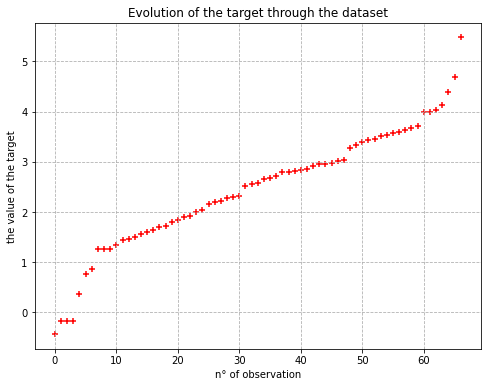

In [25]:
# plotting the evolution of the target as a function of observations' indexes
plt.figure(figsize=(8, 6))
plt.scatter(range(data_train.shape[0]), data_train[:, 8], marker = "+", color = 'red')
plt.xlabel("n° of observation")
plt.ylabel("the value of the target")
plt.title("Evolution of the target through the dataset")
plt.grid(linestyle = "--")

***Comment :*** The plot above shows that the target column is already sorted, which might skew the performance of the prediction model.  

## Exercise 4
1. Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
2. Plot the estimated error as a function of `lambda`.
3. Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
4. Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

#### <span style="color:#c83349"> <ins>Question 1 : Lambda choice optimization using 6-fold</ins> </span>

In [171]:
lmax = 40       # max value of lambda
lambda_pos = arange(0,lmax+1) 

N_test = 10     # size of the test set 

emp_errors = np.zeros((6,lmax+1))     # empirical errors
gener_errors = np.zeros((6,lmax+1))   # generalization errors

*Shuffling the dataset:  We fix a random_state for the sake of reproducibility of results.* 

In [172]:
# shuffling the dataset
shuffler = np.random.RandomState(seed=1).permutation(data_train.shape[0])
data_train1 = data_train[shuffler]

**Remark** : *In order to ensure that the dataset is well-shuflled, we can produce the same plot as previously done :* 

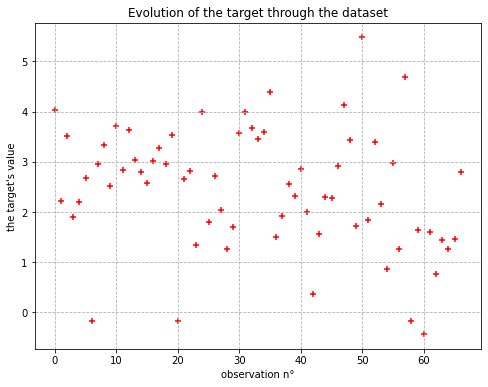

In [173]:
# plotting the evolution of the target as a function of observations' indexes
plt.figure(figsize=(8, 6))
plt.scatter(range(data_train1.shape[0]), data_train1[:, 8], marker = "+", color = 'red')
plt.xlabel("observation n°")
plt.ylabel("the target's value")
plt.title("Evolution of the target through the dataset")
plt.grid(linestyle = "--")

*Looping over test subsets and different values of $\lambda$*

In [174]:
for p in range(6):   # loop on test subsets
    # extraction of testset
    testset  = data_train1[arange(p * N_test,(p+1) * N_test), 0:9] 
    # extraction of trainset
    trainset = data_train1[hstack((arange(p * N_test), arange((p+1) * N_test,data_train.shape[0]))), 0:9]

    # normalization of entries ( # the target colmun is normalized as well )
    normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)             # inline function 
    M_train1 = np.array( [ normalize(vec) for vec in trainset.T ] ).T  # iterate on vec 
    M_train1[:, 8] = M_train1[:, 8] * (np.std(trainset[:, 8]))         # not taking into account the std dev of the target 

    # expectation and std deviation
    moy = np.array( [ np.mean(vec) for vec in trainset.T ] )
    sigma = np.array( [ np.std(vec) for vec in trainset.T ] )
    sigma[8] = 1     # std deviation of the target column is 1

    # normalizing the test set
    M_test1 = np.array([ (testset[:,k]-moy[k])/sigma[k] for k in range(M_train1.shape[1]) ] ).T

    # splitting input and target
    X_train1 = M_train1[:, 0: 8]
    t_train1 = M_train1[:, 8]

    X_test1 = M_test1[:, 0: 8]
    t_test1 = M_test1[:, 8]

    # looping over different values of lambda
    for lamb in lambda_pos:
        dag_X_train = np.dot(la.inv(np.dot(X_train1.T, X_train1) + lamb * np.identity(X_train1.shape[1])), X_train1.T)
        beta_estimated = np.dot(dag_X_train, t_train1)

        # predicting the targets
        t_train1_predicted = np.dot(X_train1, beta_estimated)    
        t_test1_predicted = np.dot(X_test1, beta_estimated)

        # computing empirical and real risk    
        emp_error = (la.norm(t_train1_predicted - t_train1))**2/(t_train1.shape[0])  # empirical error
        gener_error = (la.norm(t_test1_predicted - t_test1))**2/(t_test1.shape[0])   # generalization error
        emp_errors[p, lamb] = emp_error
        gener_errors[p, lamb] = gener_error


#### <span style="color:#c83349"> <ins>Question 2 : Estimated errors w.r.t $\lambda$</ins> </span>

In [175]:
# averaged error on the 6 training/test sets 
avg_emp_errors = np.mean(emp_errors, axis = 0)
avg_gener_errors = np.mean(gener_errors, axis = 0)

# standard variation of this error estimate 
std_emp_errors = np.std(emp_errors, axis = 0)
std_gener_errors = np.std(gener_errors, axis = 0)

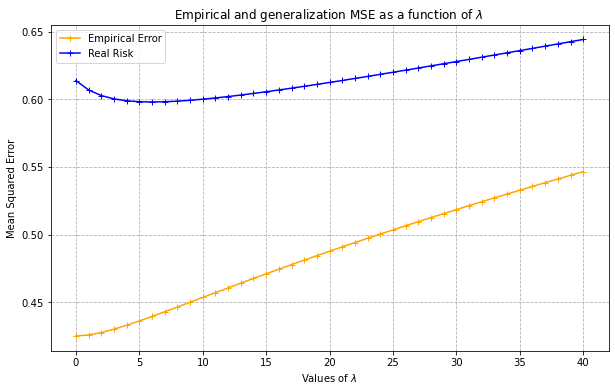

In [176]:
# plot : figure of average predicton errors w.r.t to lambda
plt.figure(figsize = (10, 6))

plt.plot(lambda_pos, avg_emp_errors, 'orange', label = "Empirical Error", marker = "+")  # average empirical risk
plt.plot(lambda_pos, avg_gener_errors, 'blue', label = "Real Risk", marker = "+")        # average real risk

plt.xlabel("Values of $\lambda$")
plt.ylabel("Mean Squared Error")
plt.title("Empirical and generalization MSE as a function of $\lambda$ ")
plt.legend()
plt.grid(linestyle = "--")
plt.show()

*Plot of the standard deviation as a function of $\lambda$*

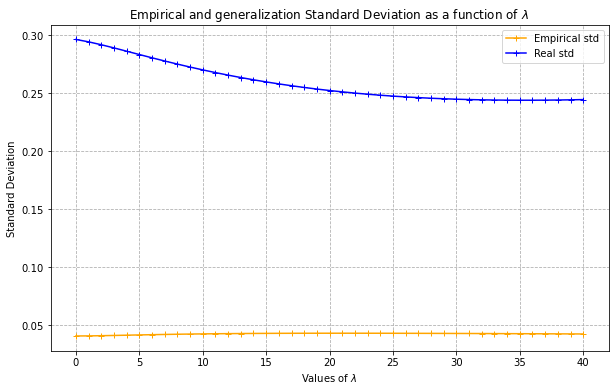

In [43]:
# plot : figure of std deviation of the estimated predicton errors w.r.t to lambda
plt.figure(figsize = (10, 6))

plt.plot(lambda_pos, std_emp_errors, 'orange', label = "Empirical std", marker = "+")   # empirical risk std deviation 
plt.plot(lambda_pos, std_gener_errors, 'blue', label = "Real std", marker = "+")        # real risk std deviation 

plt.xlabel("Values of $\lambda$")
plt.ylabel("Standard Deviation")
plt.title("Empirical and generalization Standard Deviation as a function of $\lambda$ ")
plt.legend()
plt.grid(linestyle = "--")
plt.show()

***Comment*** : The standard deviation decreases with high values of $\lambda$, which is a sign of models' robustness. However, this implies high MSE values as the former plot shows. 

#### <span style="color:#c83349"> <ins>Question 3 : Best value for $\lambda$</ins> </span>

The curve of the average real risk takes a minimum at $\lambda \approx 6$. The corresponding estimated averaged MSE is $ \approx 0.6$.

*Computing $\hat \beta$ for $\lambda = 6$*

In [81]:
# beta_hat using lambda  = 6
lamb = 6    # lambda 

# The new orthogonal projection matrix 
new_dag_X_train = np.dot(la.inv(np.dot(X_train[:, 1:].T, X_train[:, 1:]) + lamb * np.identity(X_train[:, 1:].shape[1])), X_train[:, 1:].T)

# normalized target of the training set
t_train_norm = t_train -  np.mean(t_train)  

# new estimated regression vector 
beta_hat_reg = np.dot(new_dag_X_train, t_train_norm)
beta_hat_reg = np.append(np.mean(t_train), beta_hat_reg)   # adding the bias

print(beta_hat_reg)


[ 2.45234509  0.59040544  0.28254201 -0.10457904  0.19829896  0.27896909
 -0.14312056  0.0162215   0.19642747]


*Prediction error (real risk) estimation*

In [82]:
t0 = np.mean(t_train)          # the bias 

N_test = data_test.shape[0]    # nb of rows in the test set
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  # adding ones column

# new estimated target of the test set
t_hat_reg = X_test.dot(beta_hat_reg)

mse = (la.norm(t_test - t_hat_reg))**2/(t_hat_reg.shape[0])
print(mse)

0.49195195464826774


#### <span style="color:#c83349"> <ins>Question 4 : Comments on the results</ins>  </span>

* MSE from the simple LS regression : $0.52$
* MSE using the Z-scores            : $0.45$
* MSE using LS Ridge Regression        : $0.49$
* MSE using cross-validation        : $0.6$

From the results above, ***the least MSE is scored using models WITHOUT cross-validation***. This suggests that these MSE scores are somehow optimistically estimated, since the used model is only tested on the same test set each time. Whereas ***the cross-validation model provides a more realistic estimation of the true error*** in that it averages over the errors obtained using different chunks of the test set. 

* **Note** : the MSE estimated using cross-validation has a dependency on the way the dataset is shuffled. Therefore, it might prove convenient to average the prediction error over some values of RandomState (seed) w.r.t. each value of $\lambda$.